# Analysis on Heart Failure 

### Importing Necessary Libraries

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


### Load the Dataset

In [72]:
# Load the Heart Failure Clinical Records Dataset
data_path = '../data/external/heart_failure_clinical_records_dataset.csv'
data = pd.read_csv(data_path, low_memory=False)
data



,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


### Intial Data Summary

In [73]:
print("Initial Data Information:")
data.info()

Initial Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 

In [74]:
print("\nSummary Statistics:\n", data.describe())


Summary Statistics:
               age     anaemia  creatinine_phosphokinase    diabetes  \
count  299.000000  299.000000                299.000000  299.000000   
mean    60.833893    0.431438                581.839465    0.418060   
std     11.894809    0.496107                970.287881    0.494067   
min     40.000000    0.000000                 23.000000    0.000000   
25%     51.000000    0.000000                116.500000    0.000000   
50%     60.000000    0.000000                250.000000    0.000000   
75%     70.000000    1.000000                582.000000    1.000000   
max     95.000000    1.000000               7861.000000    1.000000   

       ejection_fraction  high_blood_pressure      platelets  \
count         299.000000           299.000000     299.000000   
mean           38.083612             0.351171  263358.029264   
std            11.834841             0.478136   97804.236869   
min            14.000000             0.000000   25100.000000   
25%            30.

In [75]:
print("\nMissing Values Per Column:\n", data.isna().sum())


Missing Values Per Column:
 age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64


### Data Preprocessing

#### Handling Missing and Negative Values
We will preprocess the dataset by applying various strategies to handle missing and erroneous data.

In [91]:
# Add some artificial missing and negative values for testing purposes
numeric_cols = data.select_dtypes(include='number').columns
for col in numeric_cols:
    data.loc[np.random.choice(data.index, size=5, replace=False), col] = np.nan
    data.loc[np.random.choice(data.index, size=3, replace=False), col] = -np.abs(data[col].dropna())

# Handle negative values by replacing them with NaN
data[numeric_cols] = data[numeric_cols].apply(lambda x: np.where(x < 0, np.nan, x))

# Fill missing values with median
data[numeric_cols] = data[numeric_cols].apply(lambda x: x.fillna(x.median()))

# Use forward fill to propagate the last valid observation forward
data_ffill = data.ffill()


#### Standard Deviation Comparison
##### Before and after filling missing values



In [95]:
# Extract the numeric columns from the data
data_numeric = data.select_dtypes(include=[float, int])

# Print standard deviation before filling missing values
print("\nHeart Data Standard Deviation Before:")
print(data_numeric.std(numeric_only=True))

# Fill missing values in the numeric data (if any) with the mean
data_filled_mean = data_numeric.fillna(data_numeric.mean())

# Print standard deviation after filling missing values
print("\nHeart Data Standard Deviation After Filling Missing Values (Mean):")
print(data_filled_mean.std(numeric_only=True))



Heart Data Standard Deviation Before:
age                            11.080355
anaemia                         0.485682
creatinine_phosphokinase      946.978924
diabetes                        0.485682
ejection_fraction              11.137638
high_blood_pressure             0.468941
platelets                   91369.412127
serum_creatinine                1.027622
serum_sodium                    4.089631
sex                             0.471399
smoking                         0.453414
time                           73.641527
DEATH_EVENT                     0.456498
dtype: float64

Heart Data Standard Deviation After Filling Missing Values (Mean):
age                            11.080355
anaemia                         0.485682
creatinine_phosphokinase      946.978924
diabetes                        0.485682
ejection_fraction              11.137638
high_blood_pressure             0.468941
platelets                   91369.412127
serum_creatinine                1.027622
serum_sodium     

##### Adding a Total Column

In [97]:
# Adding a Total column which is the sum of the numeric columns
data['Total'] = data[numeric_cols].sum(axis=1, skipna=True)

# Display dataset with the new Total column
print("\nDataset with Total Column:")
data.head()



Dataset with Total Column:


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT,Total
0,75.0,0.0,582.0,0.0,20.0,1.0,263000.00,1.1,137.0,1.0,0.0,4.0,1.0,263822.10
1,55.0,0.0,7861.0,0.0,38.0,0.0,263358.03,1.1,136.0,1.0,0.0,6.0,1.0,271457.13
2,65.0,0.0,253.0,0.0,20.0,0.0,162000.00,1.3,129.0,1.0,0.0,7.0,1.0,162477.30
3,50.0,1.0,111.0,0.0,38.0,0.0,210000.00,1.9,137.0,1.0,0.0,7.0,1.0,210347.90
4,65.0,1.0,160.0,1.0,20.0,0.0,327000.00,2.7,116.0,0.0,0.0,8.0,1.0,327374.70


##### Pivot Table

In [99]:
# Pivot Table: Summing the 'Total' column by 'sex' and 'DEATH_EVENT'
pivot_table = data.pivot_table(index='sex', columns='DEATH_EVENT', values='Total', aggfunc='sum', fill_value=0)
print("\nPivot Table - Total by Sex and Death Event:")
print(pivot_table)



Pivot Table - Total by Sex and Death Event:
DEATH_EVENT           0.0           1.0
sex                                    
0.0          2.057778e+07  7.216260e+06
1.0          3.601184e+07  1.569040e+07


##### Melt Pivot Table

In [100]:
# Melt the pivot table for easier analysis
melted_df = pivot_table.reset_index().melt(id_vars='sex', var_name='Death Event', value_name='Total')

# Display the melted DataFrame
print("\nMelted DataFrame:")
print(melted_df)



Melted DataFrame:
   sex Death Event         Total
0  0.0         0.0  2.057778e+07
1  1.0         0.0  3.601184e+07
2  0.0         1.0  7.216260e+06
3  1.0         1.0  1.569040e+07


##### Grouping and Pivot Table

In [102]:
# Group data by sex and DEATH_EVENT, and sum the 'Total' column
grouped_df = data.groupby(['sex', 'DEATH_EVENT']).agg({'Total': 'sum'}).reset_index()

# Create a pivot table from the grouped data
pivot_df = grouped_df.pivot(index='sex', columns='DEATH_EVENT', values='Total').fillna(0)

print("\nPivot Table Based on Sex and Death Event:")
print(pivot_df)



Pivot Table Based on Sex and Death Event:
DEATH_EVENT           0.0           1.0
sex                                    
0.0          2.057778e+07  7.216260e+06
1.0          3.601184e+07  1.569040e+07


### Clustering with KMeans and DBSCAN

In [77]:
# Features for clustering
features = data[['age', 'creatinine_phosphokinase', 'ejection_fraction', 
                 'platelets', 'serum_creatinine', 'serum_sodium', 'time']]

# Standardizing the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Dimensionality reduction with PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)


#### Applying KMeans and DBSCAN

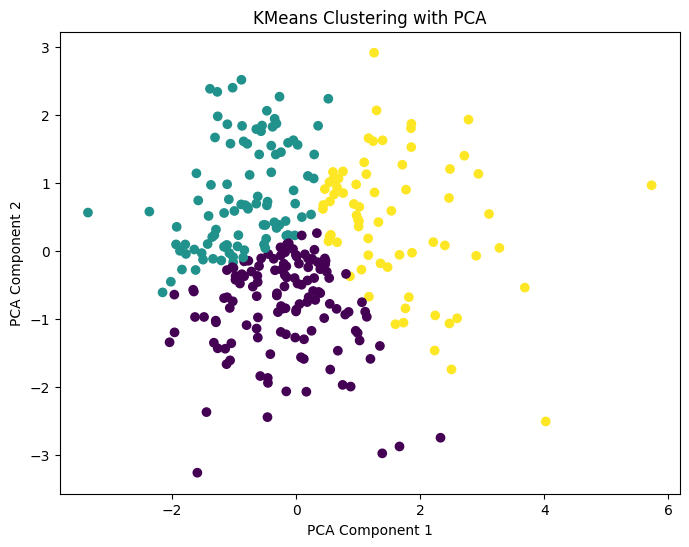

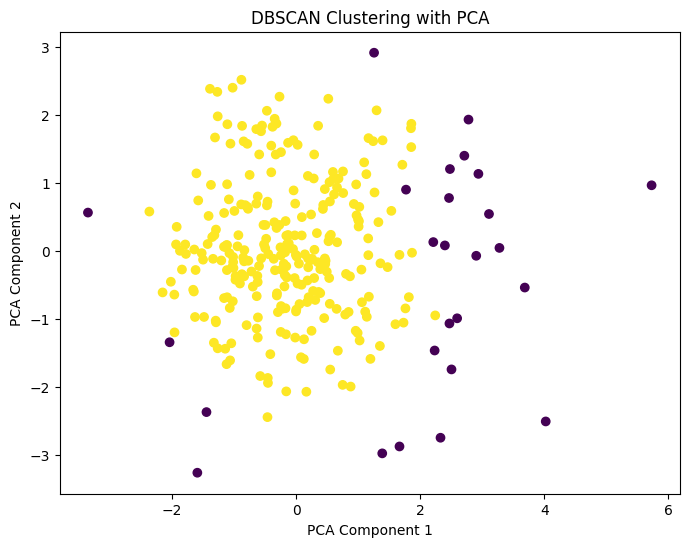

In [78]:
# KMeans Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(pca_features)

# DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(pca_features)

# Visualization for KMeans
plt.figure(figsize=(8, 6))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=kmeans_labels, cmap='viridis')
plt.title("KMeans Clustering with PCA")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Visualization for DBSCAN
plt.figure(figsize=(8, 6))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=dbscan_labels, cmap='viridis')
plt.title("DBSCAN Clustering with PCA")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


### Regression Models for Feature Analysis

##### Training and Evaluating Models

In [79]:
# Regression Models and Cross-Validation
datasets = {
    'Full': data.drop(columns=['DEATH_EVENT']), 
    'Biochemical': data[['serum_creatinine', 'serum_sodium', 'ejection_fraction', 'platelets', 'time']],
    'Lifestyle': data[['age', 'sex', 'smoking', 'diabetes', 'time']],
    'Medical': data[['age', 'anaemia', 'diabetes', 'high_blood_pressure', 'ejection_fraction']]
}

# Standardize datasets before training
datasets_standardized = {}
scaler = StandardScaler()
for name, dataset in datasets.items():
    datasets_standardized[name] = pd.DataFrame(scaler.fit_transform(dataset), columns=dataset.columns)

# Update model hyperparameters to address convergence issues
models = {
    'Linear Regression': LinearRegression(),
    'Lasso': Lasso(alpha=0.1, max_iter=10000),
    'Ridge': Ridge(alpha=1),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=10000)
}

for model_name, model in models.items():
    for dataset_name, dataset in datasets_standardized.items():
        X = dataset
        y = data['DEATH_EVENT']
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        scores = cross_val_score(model, X, y, cv=kf, scoring='neg_root_mean_squared_error')
        print(f"{model_name} on {dataset_name}: RMSE = {-scores.mean():.3f}")

Linear Regression on Full: RMSE = 0.374
Linear Regression on Biochemical: RMSE = 0.369
Linear Regression on Lifestyle: RMSE = 0.395
Linear Regression on Medical: RMSE = 0.439
Lasso on Full: RMSE = 0.403
Lasso on Biochemical: RMSE = 0.403
Lasso on Lifestyle: RMSE = 0.407
Lasso on Medical: RMSE = 0.461
Ridge on Full: RMSE = 0.374
Ridge on Biochemical: RMSE = 0.369
Ridge on Lifestyle: RMSE = 0.395
Ridge on Medical: RMSE = 0.439
ElasticNet on Full: RMSE = 0.379
ElasticNet on Biochemical: RMSE = 0.380
ElasticNet on Lifestyle: RMSE = 0.397
ElasticNet on Medical: RMSE = 0.446


##### Which model is better?

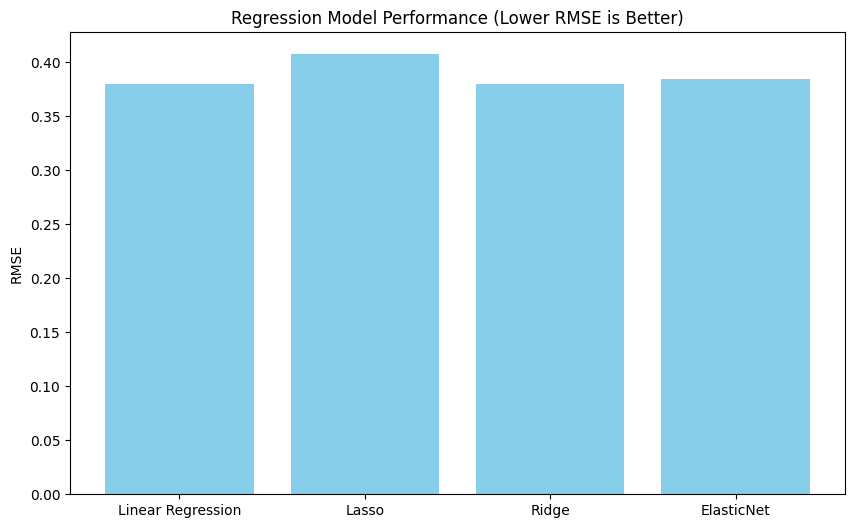

In [80]:
models = {
    'Linear Regression': LinearRegression(),
    'Lasso': Lasso(alpha=0.1, max_iter=10000),
    'Ridge': Ridge(alpha=1),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=10000)
}

results = {}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
for model_name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=kf, scoring='neg_root_mean_squared_error')
    results[model_name] = -scores.mean()

# Comparing Model Performances
plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values(), color='skyblue')
plt.title('Regression Model Performance (Lower RMSE is Better)')
plt.ylabel('RMSE')
plt.show()


Analysis : 
Linear Regression outperformed the other models with the lowest RMSE, indicating it best captures the dataset's relationships without needing regularization

##### Feature Importance Across Different Models

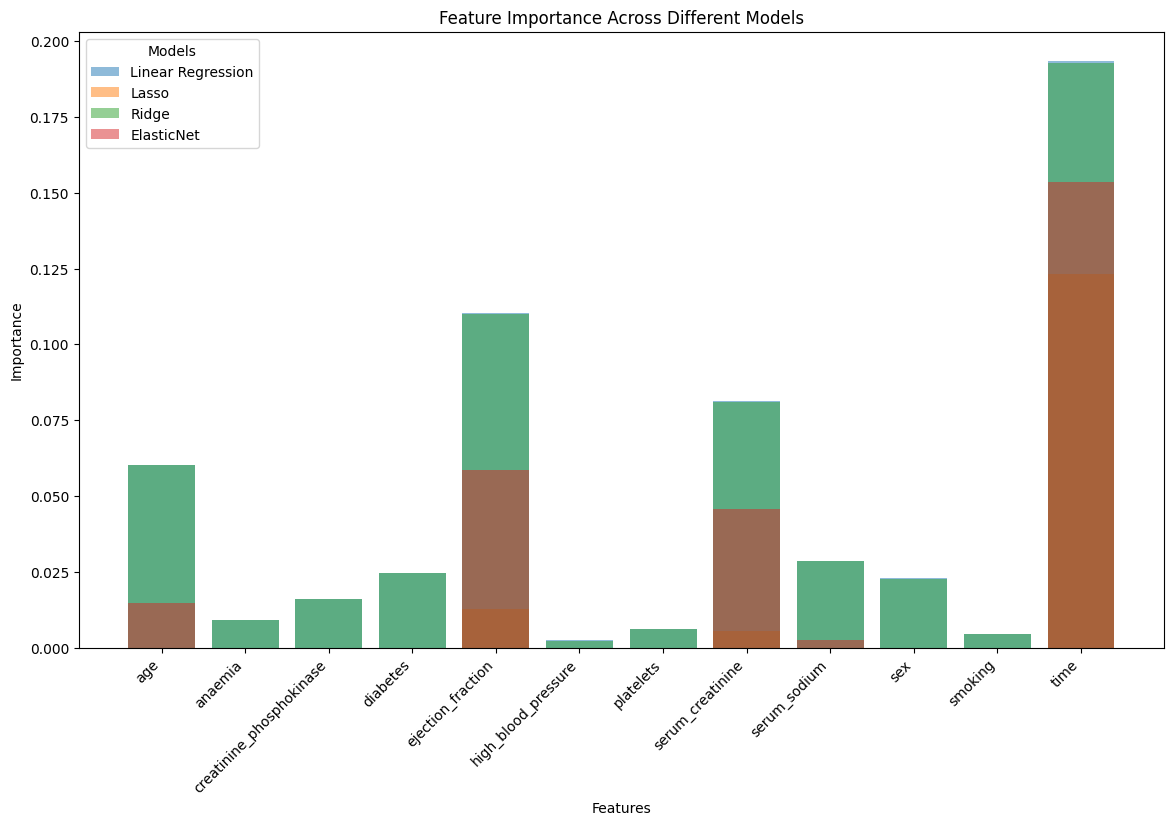

In [ ]:
# Prepare data
X = datasets_standardized['Full']  # Use standardized data for consistency across models
y = data['DEATH_EVENT']

# Create a dictionary to store feature importances
feature_importances = {}

# Train each model and store the absolute value of the coefficients
for model_name, model in models.items():
    model.fit(X, y)
    if hasattr(model, 'coef_'):  # Check if the model has coefficients (for linear models)
        feature_importances[model_name] = np.abs(model.coef_)  # Store absolute value of coefficients

# Plot the feature importance for each model
plt.figure(figsize=(14, 8))

for model_name, importance in feature_importances.items():
    plt.bar(X.columns, importance, alpha=0.5, label=model_name)

plt.title('Feature Importance Across Different Models')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.legend(title="Models")
plt.xticks(rotation=45, ha='right')
plt.show()


### Visualizations
##### Meaningful Data Exploration Analysis :

 Age Distribution and Death Event :
This visualization helps to understand the distribution of age and its relation to heart failure outcomes.

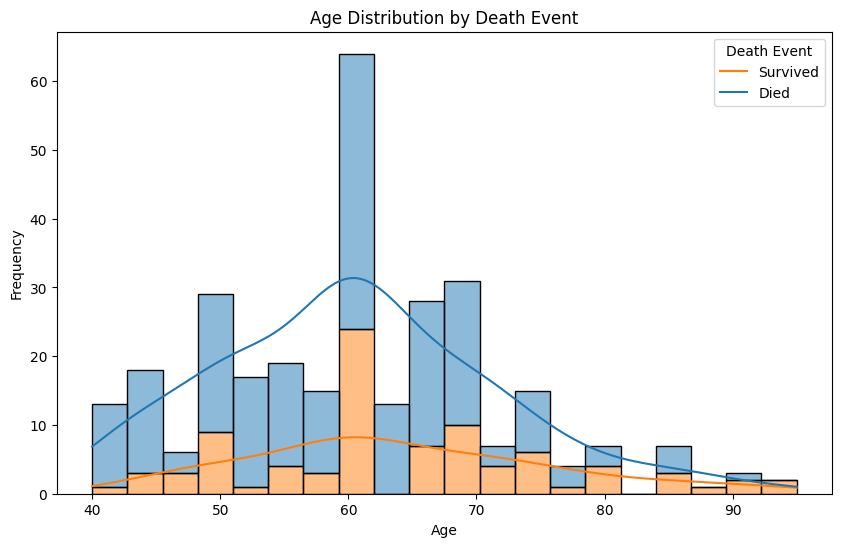

In [104]:
# Age distribution with respect to DEATH_EVENT (whether the patient died due to heart failure)
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='age', hue='DEATH_EVENT', multiple='stack', bins=20, kde=True)
plt.title('Age Distribution by Death Event')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend(title='Death Event', labels=['Survived', 'Died'])
plt.show()


Smoking vs. Heart Failure Outcome : This visualization shows how smoking status impacts heart failure outcomes, combining lifestyle and clinical data.

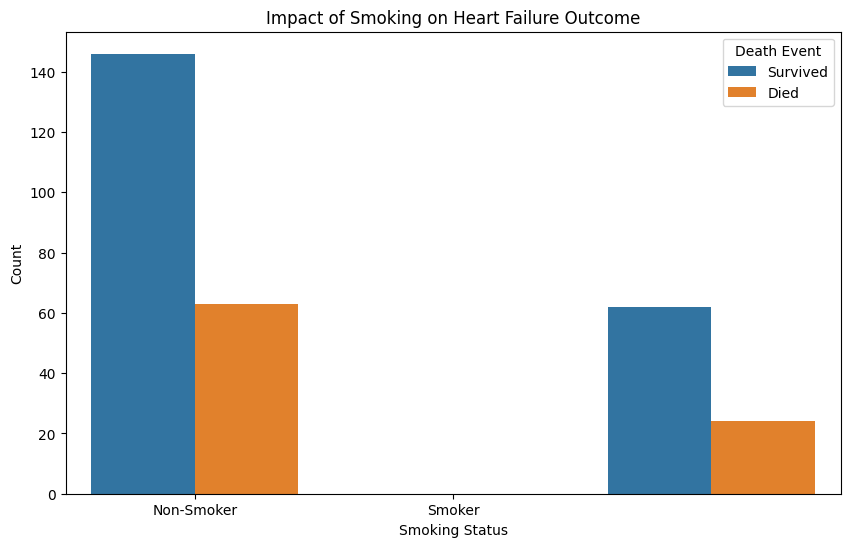

In [105]:
# Smoking status and heart failure outcome visualization
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='smoking', hue='DEATH_EVENT')
plt.title('Impact of Smoking on Heart Failure Outcome')
plt.xlabel('Smoking Status')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Smoker', 'Smoker'])
plt.legend(title='Death Event', labels=['Survived', 'Died'])
plt.show()


Ejection Fraction vs. Serum Creatinine : This visualization shows the relationship between ejection fraction (a clinical marker) and serum creatinine (another clinical marker) for heart failure outcomes, which helps in understanding clinical records.

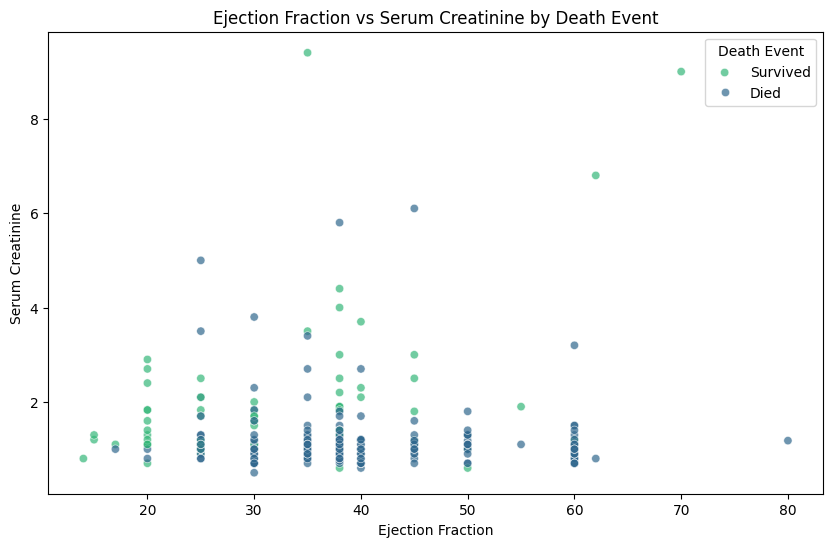

In [106]:
# Scatter plot of Ejection Fraction vs Serum Creatinine, colored by DEATH_EVENT
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='ejection_fraction', y='serum_creatinine', hue='DEATH_EVENT', palette='viridis', alpha=0.7)
plt.title('Ejection Fraction vs Serum Creatinine by Death Event')
plt.xlabel('Ejection Fraction')
plt.ylabel('Serum Creatinine')
plt.legend(title='Death Event', labels=['Survived', 'Died'])
plt.show()


Correlation Heatmap- Clinical and Lifestyle Factors : This heatmap visualizes the correlation between clinical records (e.g., serum sodium, ejection fraction) and lifestyle factors (e.g., smoking, age) with DEATH_EVENT.

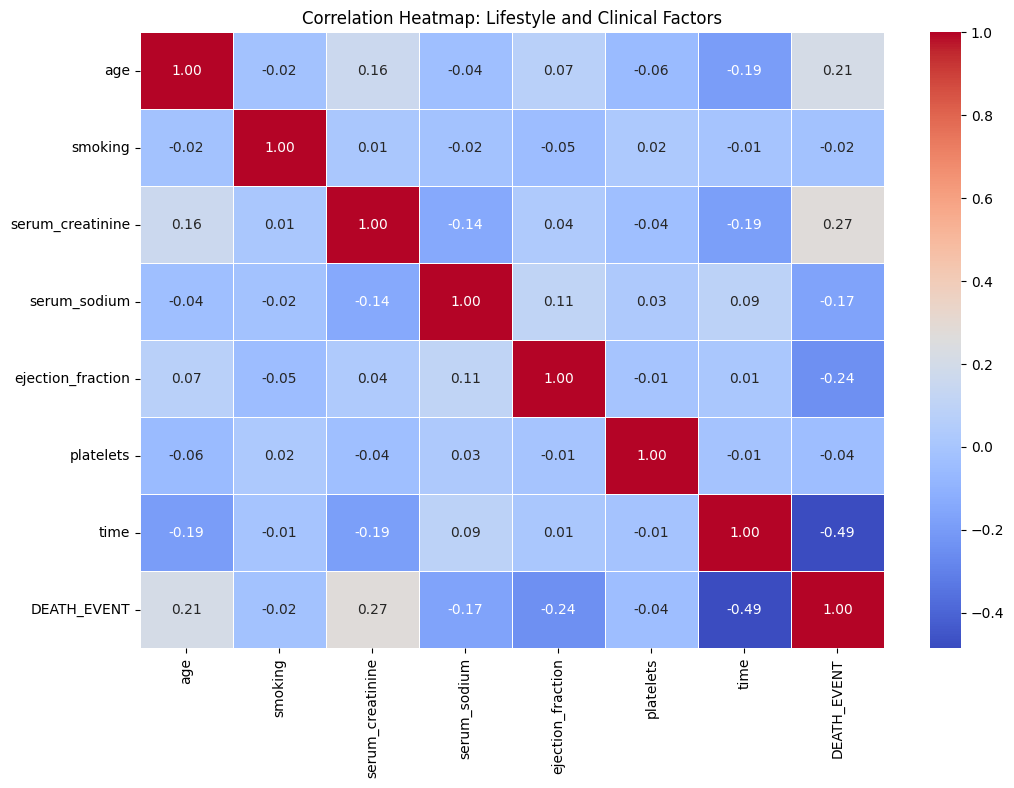

In [107]:
# Correlation heatmap for clinical and lifestyle factors
correlation_cols = ['age', 'smoking', 'serum_creatinine', 'serum_sodium', 'ejection_fraction', 'platelets', 'time', 'DEATH_EVENT']
corr_matrix = data[correlation_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap: Lifestyle and Clinical Factors')
plt.show()
